In [1]:
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

import torch
import json
import numpy as np
import matplotlib.pyplot as plt 

from torch_geometric.utils import to_dense_adj, stochastic_blockmodel_graph

from models.LASE_unshared_normalized import LASE
from models.RDPG_GD import RDPG_GD_Armijo
from models.SVD_truncate import embed_scipy, align_Xs

# Load the config file
with open('../data/data_config.json', 'r') as file:
    config = json.load(file)

# SBM-2

## M07

In [2]:
torch.manual_seed(42)

gd_steps = 10
device = 'cpu'
mask_threshold = 0.7
dataset = 'sbm2_unbalanced_positive'

d = config[dataset]['d']
p = config[dataset]['p']
n = np.array(config[dataset]['n'])*20
num_nodes = np.sum(n)

lase_M07 = LASE(d, d, gd_steps)
lase_M07.load_state_dict(torch.load(f'../saved_models/lase_{dataset}_d{d}_normalized_random_{gd_steps}steps_M0{int(mask_threshold*10)}.pt'))
lase_M07.to(device)
lase_M07.eval()

edge_index = stochastic_blockmodel_graph(n, p).to(device)
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
x = torch.rand((num_nodes, d)).to(device)


## MASK 

n_1 = 100
n_2 = 50
selected_nodes = list(range(n_1)) + list(range(n[0],n[0]+n_2))

M07_matrix = torch.ones([num_nodes, num_nodes]).squeeze(0)
for i in selected_nodes:
    nodes = (torch.rand(1, num_nodes) < mask_threshold).int()
    M07_matrix[i, :] = nodes
    M07_matrix[:, i] = nodes
M07 = M07_matrix.nonzero().t().contiguous().to(device)


x_lase_M07 = lase_M07(x, edge_index, edge_index_2, M07)
x_lase_M07 = x_lase_M07.detach()
x_lase_M07 = x_lase_M07.to('cpu')


x_gd_M07, cost, k = RDPG_GD_Armijo(x, edge_index, M07)
x_gd_M07 = x_gd_M07.detach()
x_gd_M07 = x_gd_M07.to('cpu')

x_gd_M07_10, cost, k = RDPG_GD_Armijo(x, edge_index, M07, max_iter=10)
x_gd_M07_10 = x_gd_M07_10.detach()
x_gd_M07_10 = x_gd_M07_10.to('cpu')


adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0)
masked_adj = adj_matrix*M07_matrix
x_svd_M07 = embed_scipy(masked_adj.nonzero().t().contiguous(), d)

x_gd_M07  = align_Xs(x_gd_M07, x_svd_M07)
x_lase_M07 = align_Xs(x_lase_M07, x_svd_M07)
x_gd_M07_10 = align_Xs(x_gd_M07_10, x_svd_M07)


## M05

In [12]:
mask_threshold = 0.5

lase_M05 = LASE(d, d, gd_steps)
lase_M05.load_state_dict(torch.load(f'../saved_models/lase_{dataset}_d{d}_normalized_random_{gd_steps}steps_M0{int(mask_threshold*10)}.pt'))
lase_M05.to(device)
lase_M05.eval()

## MASK 
M05_matrix = torch.ones([num_nodes, num_nodes]).squeeze(0)
for i in selected_nodes:
    nodes = (torch.rand(1, num_nodes) < mask_threshold).int()
    M05_matrix[i, :] = nodes
    M05_matrix[:, i] = nodes
M05 = M05_matrix.nonzero().t().contiguous().to(device)


x_lase_M05 = lase_M05(x, edge_index, edge_index_2, M05)
x_lase_M05 = x_lase_M05.detach()
x_lase_M05 = x_lase_M05.to('cpu')


x_gd_M05, cost, k = RDPG_GD_Armijo(x, edge_index, M05)
x_gd_M05 = x_gd_M05.detach()
x_gd_M05 = x_gd_M05.to('cpu')

x_gd_M05_10, cost, k = RDPG_GD_Armijo(x, edge_index, M05, max_iter=10)
x_gd_M05_10 = x_gd_M05_10.detach()
x_gd_M05_10 = x_gd_M05_10.to('cpu')


adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0)
masked_adj = adj_matrix*M05_matrix
x_svd_M05 = embed_scipy(masked_adj.nonzero().t().contiguous(), d)

x_gd_M05  = align_Xs(x_gd_M05, x_svd_M05)
x_lase_M05 = align_Xs(x_lase_M05, x_svd_M05)
x_gd_M05_10 = align_Xs(x_gd_M05_10, x_svd_M05)

## M03

In [4]:
mask_threshold = 0.3

lase_M03 = LASE(d, d, gd_steps)
lase_M03.load_state_dict(torch.load(f'../saved_models/lase_{dataset}_d{d}_normalized_random_{gd_steps}steps_M0{int(mask_threshold*10)}.pt'))
lase_M03.to(device)
lase_M03.eval()

## MASK 
M03_matrix = torch.ones([num_nodes, num_nodes]).squeeze(0)
for i in selected_nodes:
    nodes = (torch.rand(1, num_nodes) < mask_threshold).int()
    M03_matrix[i, :] = nodes
    M03_matrix[:, i] = nodes
M03 = M03_matrix.nonzero().t().contiguous().to(device)

x_lase_M03 = lase_M03(x, edge_index, edge_index_2, M03)
x_lase_M03 = x_lase_M03.detach()
x_lase_M03 = x_lase_M03.to('cpu')

x_gd_M03, cost, k = RDPG_GD_Armijo(x, edge_index, M03)
x_gd_M03 = x_gd_M03.detach()
x_gd_M03 = x_gd_M03.to('cpu')

x_gd_M03_10, cost, k = RDPG_GD_Armijo(x, edge_index, M03, max_iter=10)
x_gd_M03_10 = x_gd_M03_10.detach()
x_gd_M03_10 = x_gd_M03_10.to('cpu')


adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0)
masked_adj = adj_matrix*M03_matrix
x_svd_M03 = embed_scipy(masked_adj.nonzero().t().contiguous(), d)

x_gd_M03  = align_Xs(x_gd_M03, x_svd_M03)
x_lase_M03 = align_Xs(x_lase_M03, x_svd_M03)
x_gd_M03_10 = align_Xs(x_gd_M03_10, x_svd_M03)

## M01

In [6]:
mask_threshold = 0.1

lase_M01 = LASE(d, d, gd_steps)
lase_M01.load_state_dict(torch.load(f'../saved_models/lase_{dataset}_d{d}_normalized_random_{gd_steps}steps_M0{int(mask_threshold*10)}.pt'))
lase_M01.to(device)
lase_M01.eval()

## MASK 
M01_matrix = torch.ones([num_nodes, num_nodes]).squeeze(0)
for i in selected_nodes:
    nodes = (torch.rand(1, num_nodes) < mask_threshold).int()
    M01_matrix[i, :] = nodes
    M01_matrix[:, i] = nodes
M01 = M01_matrix.nonzero().t().contiguous().to(device)

x_lase_M01 = lase_M01(x, edge_index, edge_index_2, M01)
x_lase_M01 = x_lase_M01.detach()
x_lase_M01 = x_lase_M01.to('cpu')

x_gd_M01, cost, k = RDPG_GD_Armijo(x, edge_index, M01, max_iter=1000)
x_gd_M01 = x_gd_M01.detach()
x_gd_M01 = x_gd_M01.to('cpu')

x_gd_M01_10, cost, k = RDPG_GD_Armijo(x, edge_index, M01, max_iter=10)
x_gd_M01_10 = x_gd_M01_10.detach()
x_gd_M01_10 = x_gd_M01_10.to('cpu')


adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0)
masked_adj = adj_matrix*M01_matrix
x_svd_M01 = embed_scipy(masked_adj.nonzero().t().contiguous(), d)

x_gd_M01  = align_Xs(x_gd_M01, x_svd_M01)
x_lase_M01 = align_Xs(x_lase_M01, x_svd_M01)
x_gd_M01_10 = align_Xs(x_gd_M01_10, x_svd_M01)

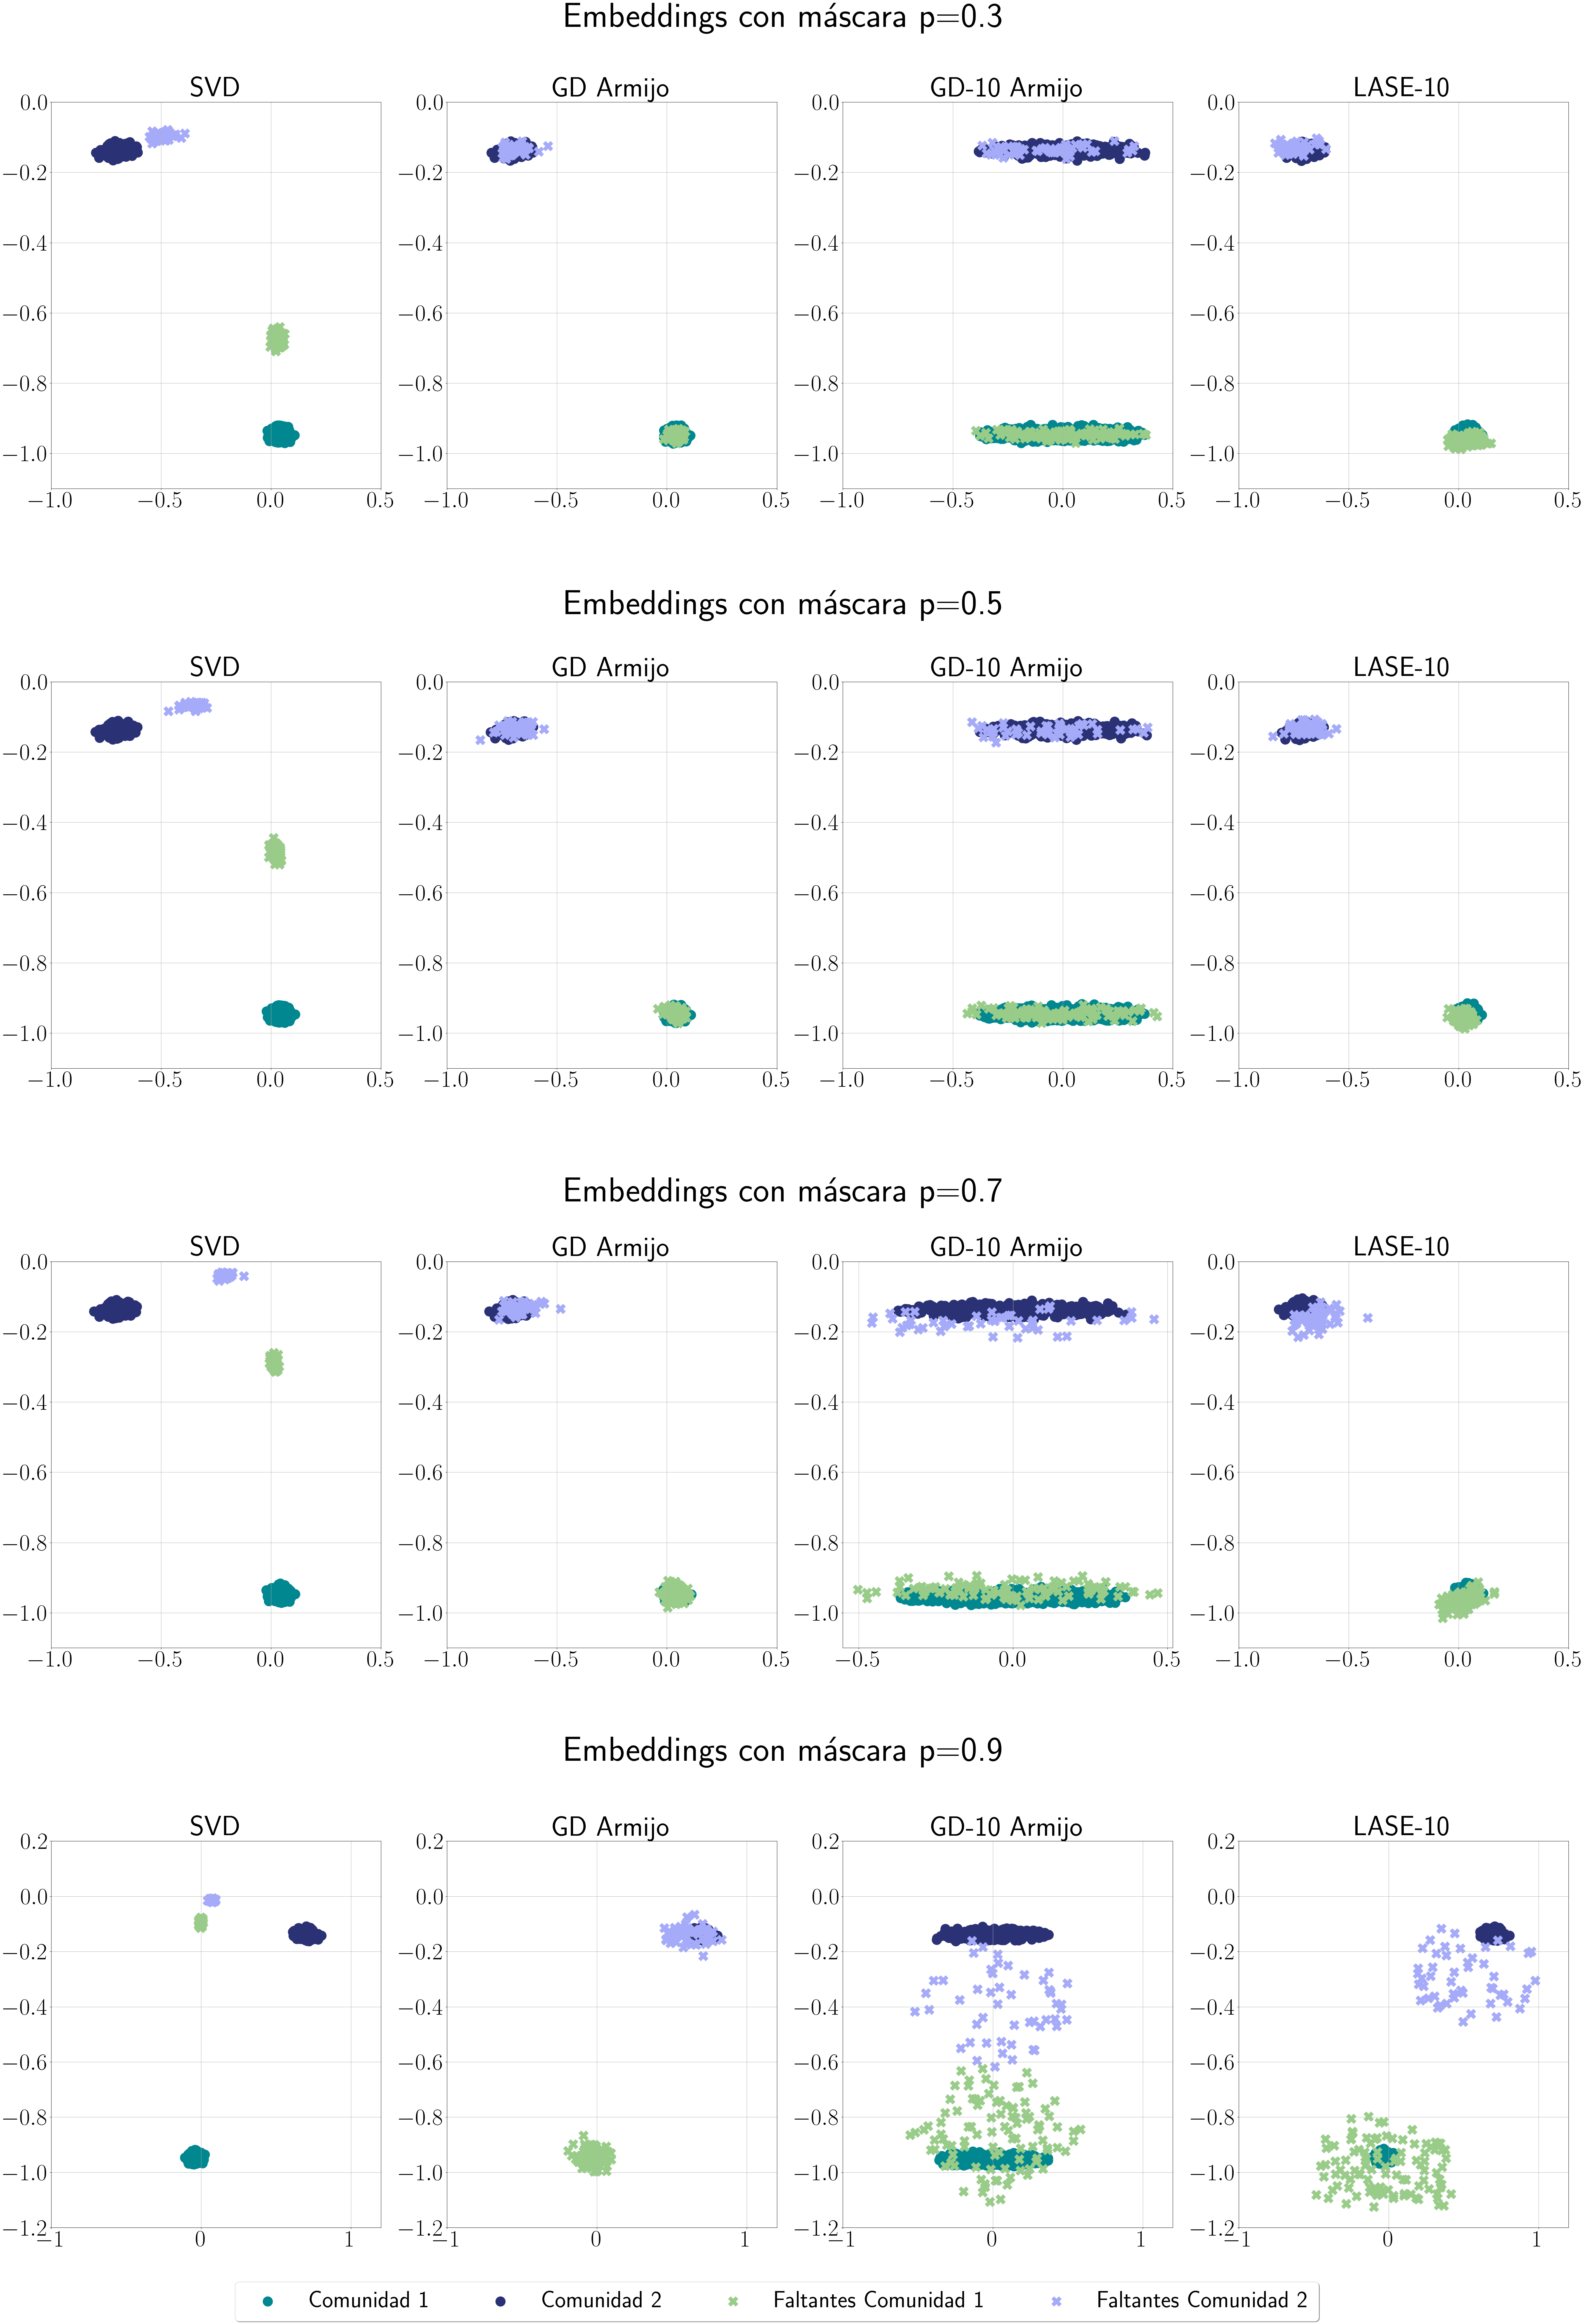

In [15]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 60
plt.rcParams['lines.markersize'] = 25
plt.rcParams['axes.grid'] = True

color_1 = (0.0, 135/255, 143/255)
color_2 = (43/255, 49/255, 117/255)
color_3 = (153/255, 204/255, 137/255)
color_4 = (165/255, 171/255, 248/255)

fig, axes = plt.subplots(4, 4, figsize =(70,100))

plt.subplots_adjust(top=0.87, hspace=0.5)

fig.text(0.5, 0.9, 'Embeddings con máscara p=0.3', ha='center', va='center', fontsize=90, fontweight='bold', transform=plt.gcf().transFigure)
axes[0,0].set_title('SVD')
axes[0,0].scatter(x_svd_M07[n_1:n[0],0],x_svd_M07[n_1:n[0]:,1], c=color_1,marker='o',label='Comunidad 1')
axes[0,0].scatter(x_svd_M07[n[0]+n_2:,0],x_svd_M07[n[0]+n_2:,1], c=color_2,marker='o',label='Comunidad 2')
axes[0,0].scatter(x_svd_M07[:n_1,0],x_svd_M07[:n_1,1], c=color_3,marker='X',label='Faltantes Comunidad 1')
axes[0,0].scatter(x_svd_M07[n[0]:n[0]+n_2,0],x_svd_M07[n[0]:n[0]+n_2,1], c=color_4,marker='X',label='Faltantes Comunidad 2')
axes[0,0].set_xlim(-1,0.5)
axes[0,0].set_ylim(-1.1,0)
axes[0,1].set_title('GD Armijo')
axes[0,1].scatter(x_gd_M07[n_1:n[0],0],x_gd_M07[n_1:n[0]:,1], c=color_1,marker='o',label='Comunidad 1')
axes[0,1].scatter(x_gd_M07[n[0]+n_2:,0],x_gd_M07[n[0]+n_2:,1], c=color_2,marker='o',label='Comunidad 2')
axes[0,1].scatter(x_gd_M07[:n_1,0],x_gd_M07[:n_1,1], c=color_3,marker='X',label='Faltantes Comunidad 1')
axes[0,1].scatter(x_gd_M07[n[0]:n[0]+n_2,0],x_gd_M07[n[0]:n[0]+n_2,1], c=color_4,marker='X',label='Faltantes Comunidad 2')
axes[0,1].set_xlim(-1,0.5)
axes[0,1].set_ylim(-1.1,0)
axes[0,2].set_title('GD-10 Armijo')
axes[0,2].scatter(x_gd_M07_10[n_1:n[0],0],x_gd_M07_10[n_1:n[0]:,1], c=color_1,marker='o',label='Comunidad 1')
axes[0,2].scatter(x_gd_M07_10[n[0]+n_2:,0],x_gd_M07_10[n[0]+n_2:,1], c=color_2,marker='o',label='Comunidad 2')
axes[0,2].scatter(x_gd_M07_10[:n_1,0],x_gd_M07_10[:n_1,1], c=color_3,marker='X',label='Faltantes Comunidad 1')
axes[0,2].scatter(x_gd_M07_10[n[0]:n[0]+n_2,0],x_gd_M07_10[n[0]:n[0]+n_2,1], c=color_4,marker='X',label='Faltantes Comunidad 2')
axes[0,2].set_xlim(-1,0.5)
axes[0,2].set_ylim(-1.1,0)
axes[0,3].set_title('LASE-10')
axes[0,3].scatter(x_lase_M07[n_1:n[0],0],x_lase_M07[n_1:n[0]:,1], c=color_1,marker='o',label='Comunidad 1')
axes[0,3].scatter(x_lase_M07[n[0]+n_2:,0],x_lase_M07[n[0]+n_2:,1], c=color_2,marker='o',label='Comunidad 2')
axes[0,3].scatter(x_lase_M07[:n_1,0],x_lase_M07[:n_1,1], c=color_3,marker='X',label='Faltantes Comunidad 1')
axes[0,3].scatter(x_lase_M07[n[0]:n[0]+n_2,0],x_lase_M07[n[0]:n[0]+n_2,1], c=color_4,marker='X',label='Faltantes Comunidad 2')
axes[0,3].set_xlim(-1,0.5)
axes[0,3].set_ylim(-1.1,0)

fig.text(0.5, 0.69, 'Embeddings con máscara p=0.5', ha='center', va='center', fontsize=90, fontweight='bold', transform=plt.gcf().transFigure)
axes[1,0].set_title('SVD')
axes[1,0].scatter(x_svd_M05[n_1:n[0],0],x_svd_M05[n_1:n[0]:,1], c=color_1,marker='o',label='Comunidad 1')
axes[1,0].scatter(x_svd_M05[n[0]+n_2:,0],x_svd_M05[n[0]+n_2:,1], c=color_2,marker='o',label='Comunidad 2')
axes[1,0].scatter(x_svd_M05[:n_1,0],x_svd_M05[:n_1,1], c=color_3,marker='X',label='Faltantes Comunidad 1')
axes[1,0].scatter(x_svd_M05[n[0]:n[0]+n_2,0],x_svd_M05[n[0]:n[0]+n_2,1], c=color_4,marker='X',label='Faltantes Comunidad 2')
axes[1,0].set_xlim(-1,0.5)
axes[1,0].set_ylim(-1.1,0)
axes[1,1].set_title('GD Armijo')
axes[1,1].scatter(x_gd_M05[n_1:n[0],0],x_gd_M05[n_1:n[0]:,1], c=color_1,marker='o',label='Comunidad 1')
axes[1,1].scatter(x_gd_M05[n[0]+n_2:,0],x_gd_M05[n[0]+n_2:,1], c=color_2,marker='o',label='Comunidad 2')
axes[1,1].scatter(x_gd_M05[:n_1,0],x_gd_M05[:n_1,1], c=color_3,marker='X',label='Faltantes Comunidad 1')
axes[1,1].scatter(x_gd_M05[n[0]:n[0]+n_2,0],x_gd_M05[n[0]:n[0]+n_2,1], c=color_4,marker='X',label='Faltantes Comunidad 2')
axes[1,1].set_xlim(-1,0.5)
axes[1,1].set_ylim(-1.1,0)
axes[1,2].set_title('GD-10 Armijo')
axes[1,2].scatter(x_gd_M05_10[n_1:n[0],0],x_gd_M05_10[n_1:n[0]:,1], c=color_1,marker='o',label='Comunidad 1')
axes[1,2].scatter(x_gd_M05_10[n[0]+n_2:,0],x_gd_M05_10[n[0]+n_2:,1], c=color_2,marker='o',label='Comunidad 2')
axes[1,2].scatter(x_gd_M05_10[:n_1,0],x_gd_M05_10[:n_1,1], c=color_3,marker='X',label='Faltantes Comunidad 1')
axes[1,2].scatter(x_gd_M05_10[n[0]:n[0]+n_2,0],x_gd_M05_10[n[0]:n[0]+n_2,1], c=color_4,marker='X',label='Faltantes Comunidad 2')
axes[1,2].set_xlim(-1,0.5)
axes[1,2].set_ylim(-1.1,0)
axes[1,3].set_title('LASE-10')
axes[1,3].scatter(x_lase_M05[n_1:n[0],0],x_lase_M05[n_1:n[0]:,1], c=color_1,marker='o',label='Comunidad 1')
axes[1,3].scatter(x_lase_M05[n[0]+n_2:,0],x_lase_M05[n[0]+n_2:,1], c=color_2,marker='o',label='Comunidad 2')
axes[1,3].scatter(x_lase_M05[:n_1,0],x_lase_M05[:n_1,1], c=color_3,marker='X',label='Faltantes Comunidad 1')
axes[1,3].scatter(x_lase_M05[n[0]:n[0]+n_2,0],x_lase_M05[n[0]:n[0]+n_2,1], c=color_4,marker='X',label='Faltantes Comunidad 2')
axes[1,3].set_xlim(-1,0.5)
axes[1,3].set_ylim(-1.1,0)


fig.text(0.5, 0.48, 'Embeddings con máscara p=0.7', ha='center', va='center', fontsize=90, fontweight='bold', transform=plt.gcf().transFigure)
axes[2,0].set_title('SVD')
axes[2,0].scatter(x_svd_M03[n_1:n[0],0],x_svd_M03[n_1:n[0]:,1], c=color_1,marker='o',label='Comunidad 1')
axes[2,0].scatter(x_svd_M03[n[0]+n_2:,0],x_svd_M03[n[0]+n_2:,1], c=color_2,marker='o',label='Comunidad 2')
axes[2,0].scatter(x_svd_M03[:n_1,0],x_svd_M03[:n_1,1], c=color_3,marker='X',label='Faltantes Comunidad 1')
axes[2,0].scatter(x_svd_M03[n[0]:n[0]+n_2,0],x_svd_M03[n[0]:n[0]+n_2,1], c=color_4,marker='X',label='Faltantes Comunidad 2')
axes[2,0].set_xlim(-1,0.5)
axes[2,0].set_ylim(-1.1,0)
axes[2,1].set_title('GD Armijo')
axes[2,1].scatter(x_gd_M03[n_1:n[0],0],x_gd_M03[n_1:n[0]:,1], c=color_1,marker='o',label='Comunidad 1')
axes[2,1].scatter(x_gd_M03[n[0]+n_2:,0],x_gd_M03[n[0]+n_2:,1], c=color_2,marker='o',label='Comunidad 2')
axes[2,1].scatter(x_gd_M03[:n_1,0],x_gd_M03[:n_1,1], c=color_3,marker='X',label='Faltantes Comunidad 1')
axes[2,1].scatter(x_gd_M03[n[0]:n[0]+n_2,0],x_gd_M05[n[0]:n[0]+n_2,1], c=color_4,marker='X',label='Faltantes Comunidad 2')
axes[2,1].set_xlim(-1,0.5)
axes[2,1].set_ylim(-1.1,0)
axes[2,2].set_title('GD-10 Armijo')
axes[2,2].scatter(x_gd_M03_10[n_1:n[0],0],x_gd_M03_10[n_1:n[0]:,1], c=color_1,marker='o',label='Comunidad 1')
axes[2,2].scatter(x_gd_M03_10[n[0]+n_2:,0],x_gd_M03_10[n[0]+n_2:,1], c=color_2,marker='o',label='Comunidad 2')
axes[2,2].scatter(x_gd_M03_10[:n_1,0],x_gd_M03_10[:n_1,1], c=color_3,marker='X',label='Faltantes Comunidad 1')
axes[2,2].scatter(x_gd_M03_10[n[0]:n[0]+n_2,0],x_gd_M03_10[n[0]:n[0]+n_2,1], c=color_4,marker='X',label='Faltantes Comunidad 2')
axes[1,3].set_xlim(-1,0.5)
axes[2,2].set_ylim(-1.1,0)
axes[2,3].set_title('LASE-10')
axes[2,3].scatter(x_lase_M03[n_1:n[0],0],x_lase_M03[n_1:n[0]:,1], c=color_1,marker='o',label='Comunidad 1')
axes[2,3].scatter(x_lase_M03[n[0]+n_2:,0],x_lase_M03[n[0]+n_2:,1], c=color_2,marker='o',label='Comunidad 2')
axes[2,3].scatter(x_lase_M03[:n_1,0],x_lase_M03[:n_1,1], c=color_3,marker='X',label='Faltantes Comunidad 1')
axes[2,3].scatter(x_lase_M03[n[0]:n[0]+n_2,0],x_lase_M03[n[0]:n[0]+n_2,1], c=color_4,marker='X',label='Faltantes Comunidad 2')
axes[2,3].set_xlim(-1,0.5)
axes[2,3].set_ylim(-1.1,0)

fig.text(0.5, 0.28, 'Embeddings con máscara p=0.9', ha='center', va='center', fontsize=90, fontweight='bold', transform=plt.gcf().transFigure)
axes[3,0].set_title('SVD')
axes[3,0].scatter(x_svd_M01[n_1:n[0],0],x_svd_M01[n_1:n[0]:,1], c=color_1,marker='o',label='Comunidad 1')
axes[3,0].scatter(x_svd_M01[n[0]+n_2:,0],x_svd_M01[n[0]+n_2:,1], c=color_2,marker='o',label='Comunidad 2')
axes[3,0].scatter(x_svd_M01[:n_1,0],x_svd_M01[:n_1,1], c=color_3,marker='X',label='Faltantes Comunidad 1')
axes[3,0].scatter(x_svd_M01[n[0]:n[0]+n_2,0],x_svd_M01[n[0]:n[0]+n_2,1], c=color_4,marker='X',label='Faltantes Comunidad 2')
axes[3,0].set_xlim(-1,1.2)
axes[3,0].set_ylim(-1.2,0.2)
axes[3,1].set_title('GD Armijo')
axes[3,1].scatter(x_gd_M01[n_1:n[0],0],x_gd_M01[n_1:n[0]:,1], c=color_1,marker='o',label='Comunidad 1')
axes[3,1].scatter(x_gd_M01[n[0]+n_2:,0],x_gd_M01[n[0]+n_2:,1], c=color_2,marker='o',label='Comunidad 2')
axes[3,1].scatter(x_gd_M01[:n_1,0],x_gd_M01[:n_1,1], c=color_3,marker='X',label='Faltantes Comunidad 1')
axes[3,1].scatter(x_gd_M01[n[0]:n[0]+n_2,0],x_gd_M01[n[0]:n[0]+n_2,1], c=color_4,marker='X',label='Faltantes Comunidad 2')
axes[3,1].set_xlim(-1,1.2)
axes[3,1].set_ylim(-1.2,0.2)
axes[3,2].set_title('GD-10 Armijo')
axes[3,2].scatter(x_gd_M01_10[n_1:n[0],0],x_gd_M01_10[n_1:n[0]:,1], c=color_1,marker='o',label='Comunidad 1')
axes[3,2].scatter(x_gd_M01_10[n[0]+n_2:,0],x_gd_M01_10[n[0]+n_2:,1], c=color_2,marker='o',label='Comunidad 2')
axes[3,2].scatter(x_gd_M01_10[:n_1,0],x_gd_M01_10[:n_1,1], c=color_3,marker='X',label='Faltantes Comunidad 1')
axes[3,2].scatter(x_gd_M01_10[n[0]:n[0]+n_2,0],x_gd_M01_10[n[0]:n[0]+n_2,1], c=color_4,marker='X',label='Faltantes Comunidad 2')
axes[3,2].set_xlim(-1,1.2)
axes[3,2].set_ylim(-1.2,0.2)
axes[3,3].set_title('LASE-10')
axes[3,3].scatter(x_lase_M01[n_1:n[0],0],x_lase_M01[n_1:n[0]:,1], c=color_1,marker='o',label='Comunidad 1')
axes[3,3].scatter(x_lase_M01[n[0]+n_2:,0],x_lase_M01[n[0]+n_2:,1], c=color_2,marker='o',label='Comunidad 2')
axes[3,3].scatter(x_lase_M01[:n_1,0],x_lase_M01[:n_1,1], c=color_3,marker='X',label='Faltantes Comunidad 1')
axes[3,3].scatter(x_lase_M01[n[0]:n[0]+n_2,0],x_lase_M01[n[0]:n[0]+n_2,1], c=color_4,marker='X',label='Faltantes Comunidad 2')
axes[3,3].set_xlim(-1,1.2)
axes[3,3].set_ylim(-1.2,0.2)

plt.legend(loc='upper center', bbox_to_anchor=(-1.4, -0.11),fancybox=True, shadow=True, ncol=4)

plt.show()